In [1]:
import pandas as pd
from sklearn.cluster import KMeans
import os
import sys
import math
import time
from datetime import datetime
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.ticker as ticker
from matplotlib import cm, colors
import copy
import numpy as np
from sklearn.manifold import TSNE
from matplotlib import pyplot as plt
import seaborn as sns
from scipy.spatial import distance_matrix
from docplex.mp.model import Model
from docplex.util.environment import get_environment
from docplex.mp.progress import *
%matplotlib inline
palette = sns.color_palette("bright", 10)

In [2]:
n=2000
sampled_df1=pd.read_csv("final_2000.csv")
df_X=sampled_df1.loc[:, sampled_df1.columns.str.contains('X')]

In [3]:
df_X.head()

,X2009.07.24,X2009.07.25,X2009.07.26,X2009.07.27,X2009.07.28,X2009.07.29,X2009.07.30,X2009.07.31,X2009.08.01,X2009.08.02,...,X2009.12.11,X2009.12.12,X2009.12.13,X2009.12.14,X2009.12.15,X2009.12.16,X2009.12.17,X2009.12.18,X2009.12.19,X2009.12.20
0,12.710,14.842,12.926,15.661,11.760,14.954,13.673,16.115,13.931,13.338,...,11.604,12.666,13.026,12.147,11.972,10.271,14.113,10.563,13.244,14.215
1,13.000,9.830,12.840,13.590,10.100,13.020,16.450,10.410,16.990,8.690,...,35.250,32.220,22.190,28.840,27.470,31.080,27.030,29.660,35.020,30.310
2,4.917,7.580,3.755,5.276,4.290,4.854,4.774,4.190,5.406,6.408,...,4.358,4.778,5.941,5.293,4.938,4.026,4.654,4.320,4.953,8.196
3,14.150,11.850,19.620,14.180,11.220,19.550,14.230,9.140,3.070,3.090,...,30.310,23.220,24.750,33.930,18.050,10.730,19.970,14.760,18.200,19.170
4,6.034,4.943,4.877,5.264,6.106,6.453,6.313,5.306,5.529,5.670,...,15.866,12.517,11.832,15.673,11.952,11.061,11.152,11.127,12.099,10.338


In [4]:
k0=30
k=9
kmeans = KMeans(n_clusters=k0, random_state=0).fit(df_X)

In [5]:
cluster_centers=pd.DataFrame(kmeans.cluster_centers_,columns=df_X.columns, index=["center"+str(i) for i in range(k0)])
frames = [df_X, cluster_centers]
df_X_1 = pd.concat(frames)
dfij=pd.DataFrame(distance_matrix(df_X_1.values, df_X_1.values), index=df_X_1.index, columns=df_X_1.index)
dij=dfij.to_numpy()
dij = np.round(dij, decimals=2)

In [6]:
colors = sns.color_palette()
c1, c2, c3, c4, c5, c6,c7,c8,c9,c10 = colors[0], colors[1], colors[2], colors[3], colors[4], colors[5],colors[6],colors[7],colors[8],colors[9]

In [7]:
def label_transform(x):
    if x in (1, 2, 3):
        return 'H'
    if x in (52, 53, 54):
        return 'L'
    return 'O'

In [8]:
def label_to_color(x):
    if x in (1,2,3):
        return c4
    if x in (52,53,54):
        return c1
    return c5

In [9]:
def label_to_alphas(x):
    if x in (1,2,3):
        return 1
    if x in (52,53,54):
        return 1
    return 0.4

In [10]:
sampled_df1['acorn_plot'] = sampled_df1['ACORN_Type'].apply(lambda x:label_transform(x))

In [12]:
H=sampled_df1[sampled_df1['acorn_plot']=='H'].index
L=sampled_df1[sampled_df1['acorn_plot']=='L'].index
O=sampled_df1[sampled_df1['acorn_plot']=='O'].index

In [13]:
def find_most_closed_points(dij,k0):
    N=dij.shape[0]
    min_index=[]
    for i in range(N-k0,N):
        mini_value=math.inf
        for j in range(N-k0):
            if dij[i,j]<mini_value:
                mini_value=dij[i,j]
                mini_index=j
        min_index.append(mini_index)
    return min_index

In [14]:
M=range(len(set(find_most_closed_points(dij,k0))))
N=range(sampled_df1.shape[0])
column1=list(set(find_most_closed_points(dij,k0)))

In [15]:
ddfij=dfij.iloc[0:n,column1]
ddfij=ddfij.to_numpy()
ddfij = np.round(ddfij, decimals=2)

In [25]:
def init_lambdas(N,lambda0):
    lambdas=np.zeros(len(N))
    lambdas.fill(lambda0)
    return lambdas

In [26]:
def LR_lower_solver(name, lambdas, N, M, H,L, k, ddfij):
    mdl=Model(name=name)
    #set variables
    DL=ddfij-lambdas[:, None]

    x=mdl.continuous_var_dict([(i,j) for i in N for j in M],lb=0.0, name="x")
    y=mdl.binary_var_dict([j for j in M],name="y")
    
    mdl.add_constraints(x[i, j] -y[j]<= 0 for i in N for j in M)
    mdl.add_constraints(x[i1, j]+x[i2, j] -1<= 0 for i1 in H for i2 in L for j in M)
    mdl.add_constraint(mdl.sum(y[j] for j in M) ==k)
    
    mdl.minimize(mdl.sum(DL[i, j]*x[i,j] for i in N for j in M))
    sol_model = mdl.solve(clean_before_solve=True)
    print("Lower solved!")
    z_FB1=sol_model.get_objective_value()
    z_FB2=lambdas.sum()
    z_FB=z_FB1+z_FB2
    L_Xij=np.zeros(shape=(len(N),len(M)))
    L_Yj=np.zeros(shape=(len(M)))
    for i in N:
        for j in M:
            L_Xij[i,j]=x[(i,j)].solution_value
    for j in M:
        L_Yj[j]=y[j].solution_value
    
    return z_FB, L_Xij, L_Yj

In [27]:
def feasible_solution(name, N, M, H, L,ddfij, k, L_Yj):
    mdl=Model(name=name)
    #set variables

    x=mdl.continuous_var_dict([(i,j) for i in N for j in M],lb=0.0, name="x")
    
    mdl.add_constraints(x[i, j] -L_Yj[j]<= 0 for i in N for j in M)
    mdl.add_constraints(mdl.sum(x[i, j] for j in M) == 1 for i in N)
    mdl.add_constraints(x[i1, j]+x[i2, j] -1<= 0 for i1 in H for i2 in L for j in M)
    
    mdl.minimize(mdl.sum(ddfij[i, j]*x[i,j] for i in N for j in M))
    sol_model = mdl.solve(clean_before_solve=True)
    print("model_feasible_solution solved!")
    z_FB=sol_model.get_objective_value()
    U_Xij=np.zeros(shape=(len(N),len(M)))
    for i in N:
        for j in M:
            U_Xij[i,j]=x[(i,j)].solution_value
    
    return z_FB, U_Xij,L_Yj

In [28]:
def subgradient_iteration(lambdas, subgradient, z_UB_best, z_LR,  epsilon, beta):    
    if np.linalg.norm(subgradient)<0.002:
        return lambdas
    alpha = beta * ( z_UB_best - z_LR )/(np.square(subgradient).sum())
    #print(f"alpha:{alpha}")
    #print(f"subgradient^2:{np.square(subgradient).sum()}")
    #print(alpha)
    for i in range(lambdas.shape[0]):
        if (np.abs(subgradient[i])>epsilon):                
            lambdas[i] = max(lambdas[i] - alpha * subgradient[i], 0)
    #print(f"subgradient: {subgradient}, step: {subgradient*alpha}, lambdas: {lambdas}")
    return lambdas

In [29]:
def xij_to_label(U_Xij):
    labels=[]
    for i in N:
        for j in M:
            if U_Xij[i,j]!=0:
                labels.append(j)
    return labels

In [30]:
def solve_lagrangian_dual(N,M,H,L,O, ddfij,k,epsilon,beta,iterations,lambda0):
    z_LB=np.full(iterations, -np.inf)
    z_UB=np.full(iterations, np.inf)
    z_LR=np.zeros(iterations)
    z_FB=np.zeros(iterations)
    #z_Optimal=np.full(iterations+1, 10515)21450
    #z_Optimal=np.full(iterations+1, 21450)
    lambdas=init_lambdas(N,lambda0)
    _lambdas = [lambdas] 
    time1=[]
    labels_list=[]
    Y_list=[]
    
    for t in range(iterations):

        start11=datetime.now()
        z_LR[t], L_Xij, L_Yj=LR_lower_solver(name="LowerModel",lambdas=lambdas, N=N, M=M, H=H,L=L, k=k, ddfij=ddfij)
        z_FB[t], U_Xij, L_Yj =feasible_solution(name="UpperModel", N=N, M=M, H=H,L=L,ddfij=ddfij, k=k, L_Yj=L_Yj)

          
        z_UB[t]= min(z_FB[t], z_UB[t])
        z_UB_best=min(z_UB)
        z_LB[t] = max(z_LB[t], z_LR[t])
        z_LB_best=max(z_LB)
        
        subgradient = L_Xij.sum(axis=1)-1
        lambdas=subgradient_iteration(lambdas, subgradient, z_UB_best, z_LR[t],epsilon, beta)
        if t % math.ceil(iterations/2) == 0:
            beta=beta/2
        if t % math.ceil(iterations/3) == 0:
            beta=beta/3
        timerecord=datetime.now()-start11
        time1.append(timerecord)
        Y_list.append(L_Yj)
        labels=xij_to_label(U_Xij)
        labels_list.append(labels)
        #pd.DataFrame(L_Xij).to_csv('L_Xij' + str(t) + '.csv')
        #pd.DataFrame(U_Xij).to_csv('U_Xij' + str(t) + '.csv')
        #pd.DataFrame(L_Yj).to_csv('L_Yj' + str(t) + '.csv')

        _lambdas.append(lambdas.copy())

        print(t)
        print(f"z_FB_best:{z_FB[t]}") 
        print(f"z_LR_best:{z_LR[t]}")
    
    return z_FB[:iterations],z_UB[:iterations],z_LB[:iterations],z_LR[:iterations],_lambdas,time1,labels_list, labels,Y_list

In [31]:
start2=datetime.now()
z_FB, z_UB, z_LB,z_LR,_lambdas,time1,labels_list,labels,Y_list=solve_lagrangian_dual(N=N,M=M,H=H,L=L,O=O,ddfij=ddfij,k=k,epsilon=0.1, beta=2,iterations=100,lambda0=100)
print(datetime.now()-start2)

Lower solved!
model_feasible_solution solved!
0
z_FB_best:120675.38
z_LR_best:-357454.7400000006
Lower solved!
model_feasible_solution solved!
1
z_FB_best:108283.38
z_LR_best:22233.51020370212
Lower solved!
model_feasible_solution solved!
2
z_FB_best:101327.61999999997
z_LR_best:43423.970207264545
Lower solved!
model_feasible_solution solved!
3
z_FB_best:103990.10999999999
z_LR_best:59999.20067400583
Lower solved!
model_feasible_solution solved!
4
z_FB_best:96548.57999999997
z_LR_best:70271.92580987726
Lower solved!
model_feasible_solution solved!
5
z_FB_best:114421.47000000002
z_LR_best:75945.42688335478
Lower solved!
model_feasible_solution solved!
6
z_FB_best:96806.62
z_LR_best:79989.32551335738
Lower solved!
model_feasible_solution solved!
7
z_FB_best:118440.04000000001
z_LR_best:82608.38156527394
Lower solved!
model_feasible_solution solved!
8
z_FB_best:98391.82999999999
z_LR_best:84260.87204555579
Lower solved!
model_feasible_solution solved!
9
z_FB_best:98116.17999999996
z_LR_be

Lower solved!
model_feasible_solution solved!
81
z_FB_best:93367.26
z_LR_best:91513.39299594557
Lower solved!
model_feasible_solution solved!
82
z_FB_best:93679.24999999999
z_LR_best:91521.64782661683
Lower solved!
model_feasible_solution solved!
83
z_FB_best:93904.88
z_LR_best:91521.51600144646
Lower solved!
model_feasible_solution solved!
84
z_FB_best:93367.26
z_LR_best:91526.99312519807
Lower solved!
model_feasible_solution solved!
85
z_FB_best:93904.88
z_LR_best:91531.46962635111
Lower solved!
model_feasible_solution solved!
86
z_FB_best:93679.24999999999
z_LR_best:91535.06314436591
Lower solved!
model_feasible_solution solved!
87
z_FB_best:93367.26
z_LR_best:91535.19749979941
Lower solved!
model_feasible_solution solved!
88
z_FB_best:93200.79000000001
z_LR_best:91542.86552227022
Lower solved!
model_feasible_solution solved!
89
z_FB_best:93367.26
z_LR_best:91533.70957837248
Lower solved!
model_feasible_solution solved!
90
z_FB_best:93200.79000000001
z_LR_best:91551.69389182977
Lowe

In [34]:
pd.DataFrame(labels_list).T.to_csv("k_means_LR_equa_labels_list.csv")

In [52]:
labels=labels_list[99]

In [35]:
#output result
iterations=range(1,101)
df_result = pd.DataFrame({'iterations':iterations,'z_LB':z_LB,'z_LR':z_LB ,'z_UB':z_UB,'z_FB':z_FB,'time':time1[0:100]})
df_result.to_csv('k_means_LR_equality_results.csv')

In [36]:
df_result.tail()

,iterations,z_LB,z_LR,z_UB,z_FB,time
95,96,91566.048574,91566.048574,93679.25,93679.25,0 days 00:00:35.395915
96,97,91566.132327,91566.132327,93367.26,93367.26,0 days 00:00:36.719629
97,98,91571.803564,91571.803564,93679.25,93679.25,0 days 00:00:34.751659
98,99,91569.778883,91569.778883,93904.88,93904.88,0 days 00:00:35.369688
99,100,91573.084926,91573.084926,93367.26,93367.26,0 days 00:00:35.658138


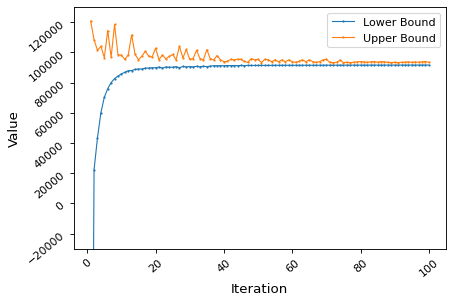

In [41]:
#plot UB and LB
ax = plt.figure(figsize=(6, 4), dpi=80).add_subplot(111)
ax.plot(df_result['iterations'], df_result['z_LR'], linewidth = 1,marker='o',markersize=1,label="Lower Bound")
ax.plot(df_result['iterations'], df_result['z_FB'], linewidth = 1,marker='o',markersize=1,label="Upper Bound")
#ticklabels = ['Monday','Tuesday','Thursday','Wednesday','Friday','Saturday','Sunday']
#ax.set_xticks(np.arange(0,7))
#ax.set_xticklabels(ticklabels) #add monthlabels to the xaxis
ax.tick_params(labelrotation=40)
ax.legend( loc = 'best',prop={ 'size':10})
#ax.legend(pt.columns.tolist(), loc='center left', bbox_to_anchor=(1, .5)) #add the column names as legend.
#plt.tight_layout(rect=[0, 0, 0.85, 1])
ax.set_ylim(-30000,130000)
plt.gcf().axes[0].yaxis.get_major_formatter().set_scientific(False)
plt.xlabel('Iteration',fontdict={'size':12})
plt.ylabel('Value',fontsize=12)
plt.show()

In [55]:
sampled_df2=copy.deepcopy(sampled_df1)
sampled_df2['color'] = sampled_df2['ACORN_Type'].apply(lambda x:label_to_color(x))
sampled_df2['plot'] = sampled_df2['ACORN_Type'].apply(lambda x:label_transform(x))
sampled_df2['alphas'] = sampled_df2['ACORN_Type'].apply(lambda x:label_to_alphas(x))
sampled_df2['label']=labels
kmeans_LR_equ_sampled_df2=sampled_df2.rename(columns={"acorn_label": "acorn"})
kmeans_LR_equ_sampled_df2=kmeans_LR_equ_sampled_df2.loc[:, kmeans_LR_equ_sampled_df2.columns.str.contains('X') |kmeans_LR_equ_sampled_df2.columns.str.contains('label') |kmeans_LR_equ_sampled_df2.columns.str.contains('ACORN_Type')]
kmeans_LR_equ_sampled_df2.head()

,X2009.07.24,X2009.07.25,X2009.07.26,X2009.07.27,X2009.07.28,X2009.07.29,X2009.07.30,X2009.07.31,X2009.08.01,X2009.08.02,...,X2009.12.13,X2009.12.14,X2009.12.15,X2009.12.16,X2009.12.17,X2009.12.18,X2009.12.19,X2009.12.20,ACORN_Type,label
0,12.710,14.842,12.926,15.661,11.760,14.954,13.673,16.115,13.931,13.338,...,13.026,12.147,11.972,10.271,14.113,10.563,13.244,14.215,44,4
1,13.000,9.830,12.840,13.590,10.100,13.020,16.450,10.410,16.990,8.690,...,22.190,28.840,27.470,31.080,27.030,29.660,35.020,30.310,5,28
2,4.917,7.580,3.755,5.276,4.290,4.854,4.774,4.190,5.406,6.408,...,5.941,5.293,4.938,4.026,4.654,4.320,4.953,8.196,19,14
3,14.150,11.850,19.620,14.180,11.220,19.550,14.230,9.140,3.070,3.090,...,24.750,33.930,18.050,10.730,19.970,14.760,18.200,19.170,2,28
4,6.034,4.943,4.877,5.264,6.106,6.453,6.313,5.306,5.529,5.670,...,11.832,15.673,11.952,11.061,11.152,11.127,12.099,10.338,1,6


In [56]:
colors=sampled_df2['color']
alphas=sampled_df2['alphas']
plots=sampled_df2['plot']

In [57]:
sampled_df2['label'].value_counts().to_csv('k_means_LR_equality_2000_9_value_count.csv')
pd.crosstab(kmeans_LR_equ_sampled_df2['label'],kmeans_LR_equ_sampled_df2['ACORN_Type']).to_csv('label_ACORN2000_9_k_means_LR_equality.csv')

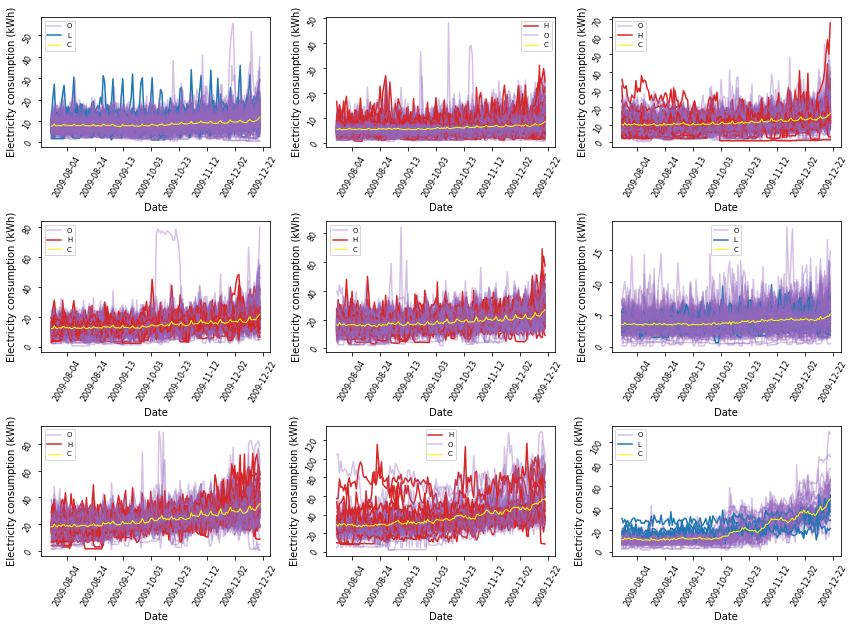

In [58]:
dat_L=kmeans_LR_equ_sampled_df2
ALL_ACORN_Type=set(kmeans_LR_equ_sampled_df2['ACORN_Type'].value_counts().values)
plot_labels=kmeans_LR_equ_sampled_df2['label'].value_counts().index.tolist()
titles=['Pattern 1','Pattern 2','Pattern 3','Pattern 4','Pattern 5','Pattern 6','Pattern 7','Pattern 8','Pattern 9']
y_mean=[]
#fig, ax = plt.subplots(nrows=3, ncols=2)
#fig.set_size_inches(20,15)
#norm = colors.Normalize(vmin=min(ALL_ACORN_Type), vmax=max(ALL_ACORN_Type))
#mapper = cm.ScalarMappable(norm=norm, cmap=cm.brg)

fig = plt.figure()
fig.set_size_inches(12,9)
for c,num in zip(plot_labels, range(1,10)):
    df0=dat_L[dat_L['label']==c]
    df0T=df0.drop('label',axis=1).T
    ACORN_Type=df0T.loc['ACORN_Type',:].values
    df0T=df0T.drop('ACORN_Type',axis=0)
    df0T.index=pd.date_range(start='7/24/2009', end='12/20/2009')
    col=df0T.shape[1]
    df0T['Mean']=df0T.mean(axis=1)
    df0T['Date']=pd.to_datetime(df0T.index,infer_datetime_format=True)
    ax = fig.add_subplot(3,3,num)
    for i in range(col):
        #ax.plot(df0T['Date'], df0T.iloc[:,i],color=mapper.to_rgba(ACORN_Type[i]))
        ax.plot(df0T['Date'], df0T.iloc[:,i],color=colors[df0T.columns[i]],alpha=alphas[df0T.columns[i]],label=plots[df0T.columns[i]])
    ax.plot(df0T['Date'], df0T['Mean'],color='yellow',linewidth=1,label='C')
    y_mean.append(df0T['Mean'].mean())
    ax.xaxis.set_major_locator(mdates.DayLocator(interval=20))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    #my_y_ticks = np.arange(0, 130, 20)
    #plt.yticks(my_y_ticks)
    ax.tick_params(axis='both', which='major', labelsize=8)
    #ax.set_ylim(0,80)
    #ax.set_title(titles[c-1])
    ax.tick_params(labelrotation=60)
    plt.ylabel('Electricity consumption (kWh)')
    plt.xlabel('Date')
    handles, labels = ax.get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    ax.legend(by_label.values(), by_label.keys(),prop={'size': 7})
    #ax.legend(loc = 'best')

# plt.xlabel('Date')
# handles, labels = ax.get_legend_handles_labels()
# by_label = dict(zip(labels, handles))
# plt.legend(by_label.values(), by_label.keys())
#plt.ylabel('Electricity consumption(KWh)')

#fig.suptitle('Residential daily electricity patterns based on Partitioning Around Medoids algorithms (k=5)',fontsize=25)
plt.tight_layout()
fig.subplots_adjust(top=0.95)
plt.show()